In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.basic_generator import BasicDataGenerator
from data_generators.standard_generator import StandardDataGenerator

from utils.tasks.task3 import Task3

## Pricing campaign

The objective in the pricing scenario is to learn the optimal price of our product to maximize the total revenue.\
In an everyday scenario a seller might try to negotiate the price of a good, trying to sell it for the maximum price at which the buyer would buy it. The seller while performing his job exploits the knowledge he has about the customers to increase his profit. 
The same can be done in our scenario, where we'll use reinforcement learning algorithms that will learn the optimal price of our product.
To explain how this algorithms work we need to introduce the concept of demand curve.
### Demand Curve
The demand curve is a function that maps the price of a good and the quantity of that good demanded at that price.
A _market demand curve_ can be used to model the price-quantity relationship for all consumers in a particular market.
The price-quantity relationship can also be expressed putting on the x-axis the price and on the y-axis the probability that a user will buy the good at that price, a function also defined as _conversion rate_.
In our scenario there are 3 different classes of users with different conversion rates:
- __Class C1__: these are users that buy every day coffee online so they'll have an overall higher conversion rate, especially for the low prices. We  assumed that some users of this category might be interested in finer types of coffee with a high price. This is expressed with a strongly decreasing demand curve, which has only a slow increase at the end.
- __Class C2__: these mixed class includes users that either buy online but are not everyday consumers or that buy frequently coffee but are not accustomed to buying online. These kind of users are the one with the lowest interest in the product and this is shown by a overall low conversion rate. The curve is pretty much linearly decreasing with a low slope.
- __Class C3__: In this class there are the users that usually don't buy online and that aren't used to buy coffee. We tought that these kind of users might be more curious to try the product so the conversion rate is overall higher w.r.t. the class C2. The trend is again linearly decreasing.

Here it is the visual representation of the conversion rates:
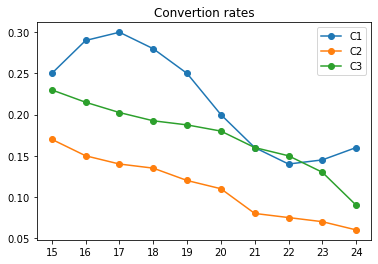



In the next section we will not discriminate the users on their class, so the _aggregate conversion rate_ must be computed as a weighted mean over the 3 conversion rates using as weights the fractions that represent the number of users belonging to the class over the total number of users.
The ending result is the following:
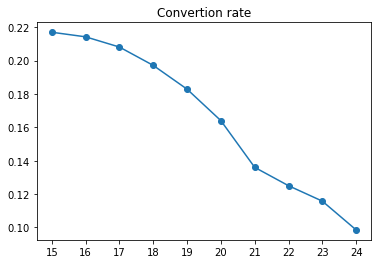

The optimal price is the one that maximizes the profit  $n_j*m_{p_j}*(\tau_{j}+1)*c_j$. \.
Given that the number of clicks $n_j$ and the margin $m_{p_j}$ are fixed in this scenario, our objective will be to find a proper estimation of the conversion rate $c_j$ and of the variable $\tau_{j}$and we'll do so through an iterative learning process. 

The main elements of our simulation are:

- __The Environment__
- __The Learner__

### Environment

The environment simulates the market in our implementation. It is a clairvoyant entity that knows a priori all the distributions of the various parameters related to the users, that are dependent on the bid and on the price. In the basic pricing scenario the bid is fixed so parameters depending on it, such as the cost per click $CPC_{j}$ and the number of clicks $n_{j}$, can be directly computed. 
The conversion rate $c_{j}$  and the number of times the user will buy again in the next 30 days $\tau_{j}$ are instead dependent on the price, so they will be computed day by day given the price $p$ chosen by the learner. \
Each day the environment iterates over the number of clicks and according to the conversion rate it samples the outcome of their decision (to buy or not to buy the product), without communicating to the learner the class to which they belong.\
The environment is perceived from the outside as a black box and the only informations obtainable by the learner are the daily reward (i.e. a list composed by all the users' outcomes and their associated $CPC_{j}$) and the number of additional purchases per day that is computed using $\tau_{j}$. It is important to notice that the latter is an information that will only be shared with the learner 30 days from when the purchase happened.


### Learner

The learner's task is to find the optimal price of the product by interacting with the environment. This mechanism can be implemented through a Multi-Armed Bandit (MAB) algorithm, whose final aim is finding the arm that maximizes the reward given by the enviroment. The pricing problem can indeed be formulated as a bandit problem by associating to each arm a price.
Although the price $p$ is a continous variable, we picked 10 prices in the range [15,24] to face the problem of having a discrete number of arms.
There are many pratical implementations of the MAB algorithm, among those we tested the Upper Confidence Bound Bandit Algorithm (UCB) and the Thompson Sampling Algorithm (TS).
Here is shown how they work in a general case.
#### UCB
First off we assume that each arm is a Bernoulli in [0,1] with unknown mean.Every arm is associated with an upper confidence bound. At every round the arm with the highest upper confidence bound is chosen which will then be updated according to the reward of the arm given by the environment. 

Here are the steps in detail, with $x_a$ being the empirical mean and n_a the number of samples of arm $a$ at time $t$:
- 1: Play once every arm $a ∈ A$
- 2: At every time $t$ play arm $a_t$ such that $a_t ← arg max_{a∈A} \{x_a + \frac {2 log(t)} {n_a(t − 1)} \} $



#### Thompson Sampling
Once again the arms are Bernoulli in [0,1] with unknown mean. For every arm, we have a prior (beta distributions) on its expected value. We will choose the arm according to the prior and update the prior according to the observed realization.

The algorithm works by repeating these steps until convergence, with $ℙ(μ_a = θ_a)$ being the prior on the expected value of $X_a$ and $θ_a$ the variable of the prior:
- 1: At every time step $t$, for every arm $a$ $θ_a ← Sample (ℙ(μ_a = θ_a))$
- 2: At every time $t$ play arm $a_t$ such that $a_t← arg max_{a∈A} \{θ_a\}$
- 3: Update the Beta distribution of arm as $(α_{a_t}, β_{a_t}) ← (α_{a_t}, β_{a_t}) + (x_{a_t,t},1 − x_{a_t,t})$

However in our particular scenario there is a big difference when we want to compute the arm to be pulled.
Indeed in the general case the condition to choose is calculated directly on the value of the pulled arm. This doesn't happen in our scenario, where the value of the arm is the list of outcomes of all the users, whose average value with a number of values that tend to infinity approximate the conversion rate $c_{j}$. The actual value on which we should discriminate is instead the profit equal to $m_{p_j}*(\tau_{j}+1)*c_j$. \
So in UCB the empirical mean that is calculated based on the outcome of the enviroment will approximate the conversion rate and the updated condition is $a_t ← arg max_{a∈A} \{x_a*m_{p_j}*(\tau_{j}+1) + \frac {2 log(t)} {n_a(t − 1)} \} $ .
The same happens in the TS approach where the beta distribution approximates the conversion rate and the new condition to choose the arm to play is $a_t← arg max_{a∈A} \{θ_a*m_{p_j}*(\tau_{j}+1)\}$
Notice that the variable $\tau_{j}$ must also be computed and this is done by averaging, for each price (arm), the number of times the users come back to buy.

The algorithm that have been implemented for this task are 